# Sprint　機械学習スクラッチ　ロジスティック回帰  

＜目的＞  
- スクラッチを通してロジスティック回帰を理解する
- 分類問題についての基礎を学ぶ

ロジスティック回帰のクラスをスクラッチで作成していきます。NumPyなど最低限のライブラリのみを使いアルゴリズムを実装していきます。

以下に雛形を用意してあります。このScratchLogisticRegressionクラスにコードを書き加えていってください。推定関係のメソッドは線形回帰と異なり、ラベルを出力するpredictメソッドと、確率を出力するpredict_probaメソッドの2種類を作成します。

### 【問題1】仮定関数  
ロジスティック回帰の仮定関数のメソッドをScratchLogisticRegressionクラスに実装してください。
ロジスティック回帰の仮定関数は、線形回帰の仮定関数を **シグモイド関数** に通したものです。シグモイド関数は以下の式で表されます。

$$
g(z)=\frac{1}{1+e^{-z}}
$$

線形回帰の仮定関数は次の式でした。

$$
h_\theta(x)=\boldsymbol{\theta}^T\boldsymbol{x}
$$

まとめて書くと、ロジスティック回帰の仮定関数は次のようになります。

$$
g(z)=\frac{1}{1+e^{-\boldsymbol{\theta}^T\boldsymbol{x}}}
$$

$\boldsymbol{x}$ : 特徴量ベクトル  
$\boldsymbol{\theta}$ : パラメータ（重み）ベクトル

### 【問題2】最急降下法    
最急降下法により学習させる実装を行なってください。以下の式で表されるパラメータの更新式のメソッド_gradient_descentを追加し、fit
メソッドから呼び出すようにしてください。

$$
\theta_j:=\theta_j-\alpha\frac{\partial}{\partial\theta_j}J(\boldsymbol{\theta})
$$
$$
\frac{\partial}{\partial\theta_0}J(\boldsymbol{\theta})=\frac{1}{m}\sum_{i=1}^{m}(h_\theta(x^{(i)})-y^{(i)})x_0^{(i)}\quad(j=0)
$$
$$
\frac{\partial}{\partial\theta_j}J(\boldsymbol{\theta})=\frac{1}{m}\sum_{i=1}^{m}(h_\theta(x^{(i)})-y^{(i)})x_j^{(i)}\:+\frac{\lambda}{m}\theta_j\quad(j\geq1)
$$

$\alpha$ : 学習率  
$i$ : サンプルのインデックス  
$j$ : 特徴量のインデックス  
$m$ : 入力されるデータの数  
$h_\theta()$ : 仮定関数  
$\boldsymbol{x}$ : 特徴量ベクトル  
$\boldsymbol{\theta}$ : パラメータ（重み）ベクトル  
$x^{(i)}$ : i番目のサンプルの特徴量ベクトル  
$y^{(i)}$ : i番目のサンプルの正解ラベル  
$\theta_j$ : j番目のパラメータ（重み）  
$\lambda$ : 正則化パラメータ  

### 【問題3】推定  
推定する仕組みを実装してください。ScratchLogisticRegressionクラスの雛形に含まれるpredictメソッドとpredict_probaメソッドに書き加えてください。
仮定関数 $h_\theta(x)$ の出力がpredict_probaの返り値、さらにその値に閾値を設けて1と0のラベルとしたものがpredictの返り値となります。

### 【問題4】目的関数    
以下の数式で表されるロジスティック回帰の **目的関数（損失関数）** を実装してください。そして、これをself.loss, self.val_lossに記録するようにしてください。
なお、この数式には正則化項が含まれています。

$$
J(\boldsymbol{\theta})=\frac{1}{m}\sum_{i=1}^{m}[-y^{(i)}log(h_\theta(x^{(i)}))-(1-y^{(i)})log(1-h_\theta(x^{(i)}))]+\frac{\lambda}{2m}\sum_{j=1}^{n}\theta_j^2
$$

$m$ : 入力されるデータの数  
$n$ : 特徴量の数 
$h_\theta()$ : 仮定関数  
$\boldsymbol{x}$ : 特徴量ベクトル  
$\boldsymbol{\theta}$ : パラメータ（重み）ベクトル  
$x^{(i)}$ : i番目のサンプルの特徴量ベクトル  
$y^{(i)}$ : i番目のサンプルの正解ラベル  
$\theta_j$ : j番目のパラメータ（重み）  
$\lambda$ : 正則化パラメータ  

In [1]:
import numpy as np
import random
from sklearn import datasets
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
%matplotlib inline
from sklearn import metrics 
from sklearn.linear_model import SGDClassifier

In [2]:
class ScratchLogisticRegression():
    """
    ロジスティック回帰のスクラッチ実装

    Parameters
    ----------
    num_iter : int
      イテレーション数
    lr : float
      学習率
    C : float
      正則化項
    no_bias : bool
      バイアス項を入れない場合はTrue
    verbose : bool
      学習過程を出力する場合はTrue

    Attributes
    ----------
    self.coef_ : 次の形のndarray, shape (n_features,)
      パラメータ
    self.loss : 次の形のndarray, shape (self.iter,)
      訓練データに対する損失の記録
    self.val_loss : 次の形のndarray, shape (self.iter,)
      検証データに対する損失の記録

    """
    def __init__(self, num_iter, lr, C, bias, verbose):
        # ハイパーパラメータを属性として記録
        self.iter = num_iter
        self.lr = lr
        # λは予約名のため、C(=1/λ)として使用
        self.C = C
        self.bias = bias
        self.verbose = verbose
        # 損失を記録する配列を用意
        self.loss = np.zeros(self.iter)
        self.val_loss = np.zeros(self.iter)
        
    def _logistic_hypothesis(self, X):
        """
        ロジスティック回帰の仮定関数を計算する

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
          訓練データ

        Returns
        -------
          次の形のndarray, shape (n_samples, 1)
          線形の仮定関数による推定結果

        """
        z = X @ self.coef_
        return 1. / (1. + np.exp(-z))
    
    def _gradient_descent(self, X, y):
        """
        最急降下法によりパラメーターを更新する

    　　Parameters
    　　----------
    　　X : 次の形のndarray, shape (n_samples, n_features)
      　　訓練データ
    　　y : 次の形のndarray, shape (n_samples, 1)
      　　正解データ
        
    　　Returns
    　　-------
      　self.coef_ : 次の形のndarray, shape (n_samples, 1)
      　　ロジスティック仮定関数による推定結果  
        """
        # 使用するかどうかは別に、正則化項なしでθ0を計算（x0は1とみて計算）
        theta0 = self.coef_[0] - np.mean(self._logistic_hypothesis(X) - y[:, np.newaxis])
        # λの乗算の代わりに、Cで除算している
        self.coef_ -= (X.T @ (self._logistic_hypothesis(X) - y[:, np.newaxis])
                       + self.coef_ / self.C) * self.lr / X.shape[0]
        # Biasがある場合のみ、θ0は変更する
        if self.bias:
            self.coef_[0] = theta0
        return self.coef_
    
    def _logloss_regularized(self, y_pred, y):
        pos = y.T @ np.log(y_pred)
        neg = (1. - y).T @ np.log(1. - y_pred)
        reg = self.coef_.T @ self.coef_
        return (-pos - neg + reg / self.C / 2) / len(y)
        

    def fit(self, X, y, X_val=None, y_val=None):
        """
        ロジスティック回帰を学習する。検証データが入力された場合はそれに対する損失と精度もイテレーションごとに計算する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        """
        if self.bias:
            X = np.insert(X, 0, 1, axis=1)
            if X_val is not None:
                X_val = np.insert(X_val, 0, 1, axis=1)
        
        # 正規分布を用いてパラメーターを初期化
        self.coef_ = np.random.normal(loc=0.0, 
                                      scale=0.01, 
                                      size=X.shape[1]).reshape(-1, 1)
        
        for i in range(self.iter):
            self.coef_ = self._gradient_descent(X, y)
            self.loss[i] = self._logloss_regularized(self._logistic_hypothesis(X), y)
            if X_val is not None:
                self.val_loss[i] = self._logloss_regularized(self._logistic_hypothesis(X_val), y_val)
        
        if self.verbose:
            print(f'loss(train)：{self.loss}')
            if X_val is not None:
                print(f'loss(validation)：{self.val_loss}')

    def predict(self, X):
        """
        ロジスティック回帰を使いラベルを推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            ロジスティック回帰による推定結果
        """
        if self.bias:
            X = np.insert(X, 0, 1, axis=1)
        probs = self._logistic_hypothesis(X)
        # 閾値は0.5とする
        return np.where(probs >= 0.5, 1, 0)
    
    def predict_proba(self, X):
        """
        ロジスティック回帰を使い確率を推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            ロジスティック回帰による推定結果
        """
        if self.bias:
            X = np.insert(X, 0, 1, axis=1)
        # ラベルが1である確率のみ返す
        return self._logistic_hypothesis(X)


### 【問題5】学習と推定  
機械学習スクラッチ入門のSprintで用意したirisデータセットのvirgicolorとvirginicaの2値分類に対してスクラッチ実装の学習と推定を行なってください。  
scikit-learnによる実装と比べ、正しく動いているかを確認してください。  
AccuracyやPrecision、Recallなどの指標値はscikit-learnを使用してください。

In [3]:
# irisデータセット
iris = datasets.load_iris()

# virgicolorとvirginica(51行目以降)を抽出
# 特徴量は4つ全て
X = iris.data[50:, :]
y = iris.target[50:][:, np.newaxis]
data = np.hstack([X, y])
df_iris = pd.DataFrame(data, columns=['sepal_length', 
                                     'sepal_width', 
                                     'petal_length', 
                                     'petal_width',
                                     'Species'])
print('< Iris >')
display(df_iris.head())
display(np.shape(df_iris))

< Iris >


,sepal_length,sepal_width,petal_length,petal_width,Species
0,7.0,3.2,4.7,1.4,1.0
1,6.4,3.2,4.5,1.5,1.0
2,6.9,3.1,4.9,1.5,1.0
3,5.5,2.3,4.0,1.3,1.0
4,6.5,2.8,4.6,1.5,1.0


(100, 5)

In [4]:
# 前処理
X = df_iris.iloc[:, :-1].values
y = df_iris.iloc[:, -1].values

# 訓練/検証データに3:1で分割
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y)

# 標準化
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

print(np.shape(X_train_std))
print(np.shape(X_test_std))
print(np.shape(y_train))
print(np.shape(y_test))

(75, 4)
(25, 4)
(75,)
(25,)


In [5]:
# 決定境界描画関数
def decision_region(X, y, model, step=0.01, title='decision region', xlabel='xlabel', ylabel='ylabel', target_names=['0', '1']):
    """
    2値分類を2次元の特徴量で学習したモデルの決定領域を描く。
    背景の色が学習したモデルによる推定値から描画される。
    散布図の点は訓練データまたは検証データである。

    Parameters
    ----------------
    X : ndarray, shape(n_samples, n_features)
        特徴量
    y : ndarray, shape(n_samples,)
        ラベル
    model : object
        学習したモデルのインスンタスを入れる
    step : float, (default : 0.1)
        推定値を計算する間隔を設定する
    title : str
        グラフのタイトルの文章を与える
    xlabel, ylabel : str
        軸ラベルの文章を与える
    target_names= : list of str
        凡例の一覧を与える
    """
    # setting
    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2
    # pred
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step), np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)
    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
    for i, target in enumerate(set(y)):
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker='o')
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

In [6]:
# 評価関数
def evaluate(y_true, y_pred):
    """
    2値分類の評価指標を計算する
    """
    acc = metrics.accuracy_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred)
    recall = metrics.recall_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred)
    confusion = metrics.confusion_matrix(y_test, y_pred)
    return acc, precision, recall, f1, confusion

=== Logistic Regression (scikit-learn) ===

< Decision Region(train/validation) >


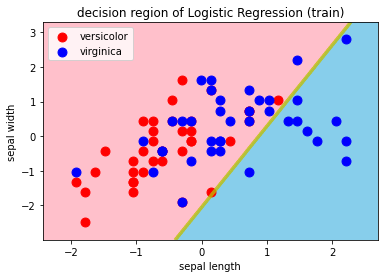

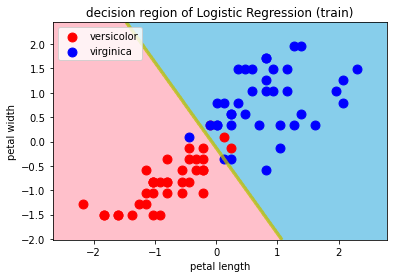

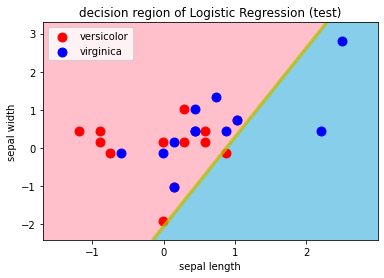

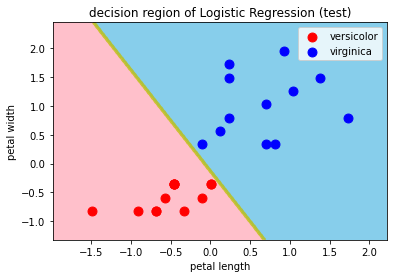

< Metrics(validation) >
Accuracy : 0.920
Precision : 1.000
Recall : 0.846
F1 : 0.917
confusion matrix 
 [[11  2]
 [ 0 12]]



In [7]:
# scirkit-lean
print("=== Logistic Regression (scikit-learn) ===\n")

# 可視化のため3つのインスタンス作成
sgd = SGDClassifier(loss="log")
sgd_1 = SGDClassifier(loss="log")
sgd_2 = SGDClassifier(loss="log")

# 学習・推論
sgd.fit(X_train_std, y_train)
y_pred = sgd.predict(X_test_std)
X1_train_std = X_train_std[:, :2]
X2_train_std = X_train_std[:, 2:]
X1_test_std = X_test_std[:, :2]
X2_test_std = X_test_std[:, 2:]
sgd_1.fit(X1_train_std, y_train)
sgd_2.fit(X2_train_std, y_train)
        
# 可視化（特徴量2つの学習モデル使用）
print('< Decision Region(train/validation) >')
decision_region(X1_train_std, y_train, sgd_1, 
                title="decision region of Logistic Regression (train)",
                xlabel='sepal length', ylabel='sepal width', target_names=['versicolor', 'virginica'])
decision_region(X2_train_std, y_train, sgd_2,
                title="decision region of Logistic Regression (train)",
                xlabel='petal length', ylabel='petal width', target_names=['versicolor', 'virginica'])
decision_region(X1_test_std, y_test, sgd_1, 
                title="decision region of Logistic Regression (test)", 
                xlabel='sepal length', ylabel='sepal width', target_names=['versicolor', 'virginica'])
decision_region(X2_test_std, y_test, sgd_2, 
                title="decision region of Logistic Regression (test)",
                xlabel='petal length', ylabel='petal width', target_names=['versicolor', 'virginica'])
        
# 評価（特徴量4つの学習モデル使用）
print('< Metrics(validation) >')
print("Accuracy : {:.3f}\nPrecision : {:.3f}\nRecall : {:.3f}\nF1 : {:.3f}\nconfusion matrix \n {}\n"
          .format(*evaluate(y_test, y_pred)))

=== Logistic Regression (Scratch) ===

< Decision Region(train/validation) >


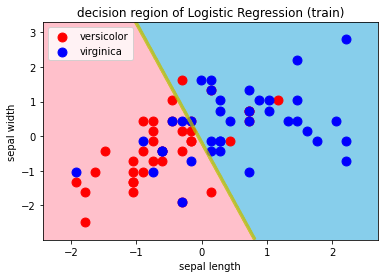

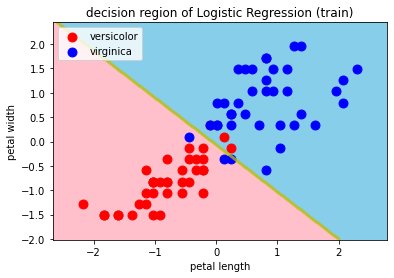

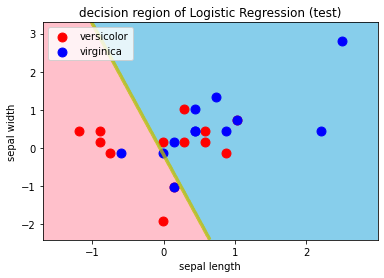

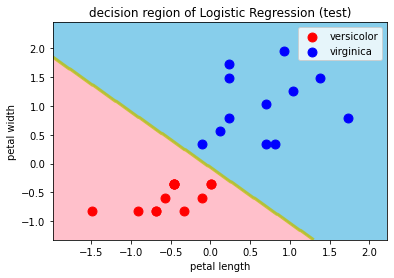

< Metrics(validation) >
Accuracy : 1.000
Precision : 1.000
Recall : 1.000
F1 : 1.000
confusion matrix 
 [[13  0]
 [ 0 12]]



In [8]:
# Scratch
print("=== Logistic Regression (Scratch) ===\n")

# yのラベルを（1/2）から（0/1）へ
y_train = y_train - 1.
y_test = y_test - 1.

# 可視化のため3つのインスタンス作成
slr = ScratchLogisticRegression(1000, 0.01, 1000, bias=True, verbose=False)
slr_1 = ScratchLogisticRegression(1000, 0.01, 1000, bias=True, verbose=False)
slr_2 = ScratchLogisticRegression(1000, 0.01, 1000, bias=True, verbose=False)

# 学習・推論
slr.fit(X_train_std, y_train, X_test_std, y_test)
y_pred = slr.predict(X_test_std)

# 結果の保存
np.savez('results.npz', slr.iter, slr.lr, slr.C, slr.coef_)

# 可視化のため2変数毎に学習
X1_train_std = X_train_std[:, :2]
X2_train_std = X_train_std[:, 2:]
X1_test_std = X_test_std[:, :2]
X2_test_std = X_test_std[:, 2:]
slr_1.fit(X1_train_std, y_train)
slr_2.fit(X2_train_std, y_train)
        
# 可視化（特徴量2つの学習モデル使用）
print('< Decision Region(train/validation) >')
decision_region(X1_train_std, y_train, slr_1, 
                title="decision region of Logistic Regression (train)",
                xlabel='sepal length', ylabel='sepal width', target_names=['versicolor', 'virginica'])
decision_region(X2_train_std, y_train, slr_2,
                title="decision region of Logistic Regression (train)",
                xlabel='petal length', ylabel='petal width', target_names=['versicolor', 'virginica'])
decision_region(X1_test_std, y_test, slr_1, 
                title="decision region of Logistic Regression (test)", 
                xlabel='sepal length', ylabel='sepal width', target_names=['versicolor', 'virginica'])
decision_region(X2_test_std, y_test, slr_2, 
                title="decision region of Logistic Regression (test)",
                xlabel='petal length', ylabel='petal width', target_names=['versicolor', 'virginica'])
        
# 評価（特徴量4つの学習モデル使用）
print('< Metrics(validation) >')
print("Accuracy : {:.3f}\nPrecision : {:.3f}\nRecall : {:.3f}\nF1 : {:.3f}\nconfusion matrix \n {}\n"
          .format(*evaluate(y_test, y_pred)))

### 【問題6】学習曲線のプロット  
学習曲線を見て損失が適切に下がっているかどうか確認してください。

In [9]:
# 学習曲線のプロット
def learning_curve(n_iter, loss, val_loss):
    plt.plot(np.arange(n_iter), loss, label='train_loss')
    plt.plot(np.arange(n_iter), val_loss, label='val_loss')
    plt.title('model loss')
    plt.xlabel('iter')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

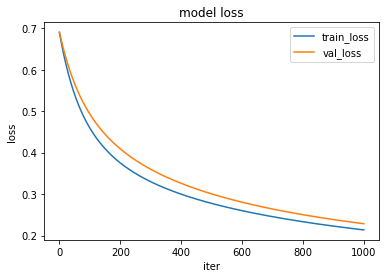

In [10]:
# 上記の学習で実行(Bias(+))
learning_curve(1000, slr.loss, slr.val_loss)

### 【問題7】決定領域の可視化    
決定領域を可視化してください。

### 【問題8】重みの保存      
検証が容易になるように、学習した重みを保存および読み込みができるようにしましょう。pickleモジュールやNumPyのnp.savezを利用します。

In [11]:
# 保存した結果の表示
results = np.load('results.npz')
print('n_iter : {}'.format(results['arr_0']))
print('α : {}'.format(results['arr_1']))
print('C = 1/λ: {}'.format(results['arr_2']))
print('Θ : \n{}'.format(results['arr_3']))

n_iter : 1000
α : 0.01
C = 1/λ: 1000
Θ : 
[[ 0.11197891]
 [ 0.31047748]
 [-0.1558916 ]
 [ 1.17211301]
 [ 1.3090807 ]]
